# Vignetting analysis for EPIC

This analysis follows on a couple of early studies:

* Statistical evaluation of the flux cross-calibration of the XMM-EPIC ([Mateos et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...496..879M/abstract));
* The non-linear X-ray/UV relation in AGNs: contribution of instrumental effects on the X-ray variability ([Elisabeta Lusso, 2018](https://ui.adsabs.harvard.edu/abs/2019AN....340..267L/abstract)).


In this notebook, I will try to extract an image of 300x300 pixels in RAWXY coordinates with the st.dev. of the flux differences, as in Lumb et al. (2004)


In [1]:
import os

import numpy as np
from scipy.stats import norm, sem
from statsmodels.stats.weightstats import DescrStatsW

from astropy.table import Table
import pandas as pd
import altair as alt

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')

## Energy bands used in 3XMM

```Basic energy bands: 	
1 	= 	0.2 -   0.5 keV 	 
2 	= 	0.5 -   1.0 keV 	  	 
3 	= 	1.0 -   2.0 keV 	  	 
4 	= 	2.0 -   4.5 keV 	  	 
5 	= 	4.5 - 12.0 keV 	  	 
Broad energy bands: 	
6 	= 	0.2 -   2.0 keV 	  	soft band, no images made, not used
7 	= 	2.0 - 12.0 keV 	  	hard band, no images made, not used
8 	= 	0.2 - 12.0 keV 	  	total band
9 	= 	0.5 -   4.5 keV 	  	XID band
```

In [2]:
#
# define the energy ranges for info
#
bands = {1:'[0.2-0.5] keV',2:'[0.5-1.0] keV',3:'[1.0-2.0] keV',4:'[2.0-4.5] keV',5:'[4.5-12.0] keV',\
        8:'[0.2-12.0] keV'}

In [3]:
#
# read the 3XMM-DR8 catalogue
#
wdir = f"{home}/XMM/3XMM"
t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.0.fits.gz')

## Source selection

We apply the following selection of sources from the `3XMM-DR8` catalogue, where `x` is one of `M1, M2` or `PN`:
1. good detection, i.e. `SUM_FLAG == 0`
2. point-like sources, i.e. `EP_EXTENT == 0`
3. at off-axis angles <= 12 arcmin, i.e. `x_OFFAX <= 12`
4. flux in [2,12] keV <= 6.0e-12 erg/cm2/s, i.e. `(x_4_FLUX + x_5_FLUX) <= 6.0e-12`, in order to avoid pile-up sources.
5. `CONFUSED == false`
6. `HIGH_BACKGROUND == false`
7. at least 200 source counts in band 8, i.e. `EP_8_CTS >= 200`
8. not too faint sources, i.e. `x_5_FLUX >= 1.0e-15`
9. High SNR in band 5, i.e. `x_5_FLUX/x_5_FLUX_ERR >= 5`

In [4]:
ntot = len(t3)
m1 = t3['SUM_FLAG'] == 0
#
m2 = t3['EP_EXTENT'] == 0
#
m3_m1 = t3['M1_OFFAX'] <= 12.0
m3_m2 = t3['M2_OFFAX'] <= 12.0
m3_pn = t3['PN_OFFAX'] <= 12.0
#
m4_m1 = (t3['M1_4_FLUX'] + t3['M1_5_FLUX']) <= 6.0e-12
m4_m2 = (t3['M2_4_FLUX'] + t3['M2_5_FLUX']) <= 6.0e-12
m4_pn = (t3['PN_4_FLUX'] + t3['PN_5_FLUX']) <= 6.0e-12
#
m5 = t3['CONFUSED'] == 0
#
m6 = t3['HIGH_BACKGROUND'] == 0
#
m7 = t3['EP_8_CTS'] >= 200.0
#
m8_m1 = (t3['M1_5_FLUX']) >= 1.0e-15
m8_m2 = (t3['M2_5_FLUX']) >= 1.0e-15
m8_pn = (t3['PN_5_FLUX']) >= 1.0e-15
#
m9_m1 = (t3['M1_5_FLUX']/t3['M1_5_FLUX_ERR']) >= 5.0
m9_m2 = (t3['M2_5_FLUX']/t3['M2_5_FLUX_ERR']) >= 5.0
m9_pn = (t3['PN_5_FLUX']/t3['PN_5_FLUX_ERR']) >= 5.0
#
#xfilter = m1*m2*m3_m1*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7*m8_m1*m8_m2*m8_pn*m9_m1*m9_m2*m9_pn
xfilter = m1*m2*m3_m1*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7
#
ix = np.where(xfilter)[0]
nx = len(ix)
print (f"Found {nx} out of {ntot} ({100*nx/ntot:.2f} %) 3XMM-DR8 sources with the filtering criteria.")

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


Found 51094 out of 775153 (6.59 %) 3XMM-DR8 sources with the filtering criteria.


In [7]:
#
# extract the selection as a table
#
tsel = t3[ix]

## Image respresentation of flux difference per CCD

Following on Lumb et al. (2004) paper, for each MOS1 or MOS2 CCD, accumulate the flux difference (PN/MOSx-1) in an image of 300x300 pixels.

We need 3x300x300 for each CCD, sum, sum2 and ncount. One to hold the running sum of delta flux, one to hold its square and one to hold the count. Then we can calculate the st.dev. image of the flux differences in pixel [i,j]: `stdev[i,j] = sum2[i,j]/ncount[i,j] - (sum[i,j]/ncount[i,j])**2`

In [40]:
xsum = np.zeros((7,600,600),dtype=np.float)
xsum2 = np.zeros((7,600,600),dtype=np.float)
xcount = np.zeros((7,600,600),dtype=np.int)
#
qtsel = {}

for xband in [1,2,3,4,5]:
    #
    # further selection per band
    #
    q1_m1 = (tsel[f'M1_{xband}_FLUX']) >= 1.0e-15
    q1_m2 = (tsel[f'M2_{xband}_FLUX']) >= 1.0e-15
    q1_pn = (tsel[f'PN_{xband}_FLUX']) >= 1.0e-15
    #
    q2_m1 = (tsel[f'M1_{xband}_FLUX']/tsel[f'M1_{xband}_FLUX_ERR']) >= 5.0
    q2_m2 = (tsel[f'M2_{xband}_FLUX']/tsel[f'M2_{xband}_FLUX_ERR']) >= 5.0
    q2_pn = (tsel[f'PN_{xband}_FLUX']/tsel[f'PN_{xband}_FLUX_ERR']) >= 5.0
    #
    qfilter = q1_m1 & q1_m2 & q1_pn & q2_m1 & q2_m2 & q2_pn
    qtsel[xband] = tsel[qfilter]
    nqt = len(qtsel[xband])
    #
    rawx = qtsel[xband]['M1_RAWX']
    rawy = qtsel[xband]['M1_RAWY']
    m1ccd = qtsel[xband]['CCDM1']
    #rawx = [int(x) for x in qtsel[xband]['M1_RAWX']]
    #rawy = [int(x) for x in qtsel[xband]['M1_RAWY']]
    #m1ccd = [int(x) for x in qtsel[xband]['CCDM1']]
    #
    m1_fx = qtsel[xband][f'M1_{xband}_FLUX']
    m2_fx = qtsel[xband][f'M2_{xband}_FLUX']
    pn_fx = qtsel[xband][f'PN_{xband}_FLUX']
    #
    m1_fx_err = qtsel[xband][f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qtsel[xband][f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qtsel[xband][f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
    #
    nx = len(ratio1)
    for i in np.arange(nx):
        if (rawx[i] <= 600 and rawy[i] <= 600 and rawx[i] > 0 and rawy[i] > 0):
            xsum[m1ccd[i]-1,rawx[i]-1,rawy[i]-1] += ratio1[i]
            xsum2[m1ccd[i]-1,rawx[i]-1,rawy[i]-1] += ratio1[i]**2
            xcount[m1ccd[i]-1,rawx[i]-1,rawy[i]-1] += 1
    if (xband == 2):
        break
    #
#

In [69]:
a = xsum[1,:,:]
b = xsum2[1,:,:]
na = xcount[1,:,:]
xstd = np.divide(b, na, out=np.zeros_like(a), where=na!=0) - (np.divide(a, na, out=np.zeros_like(a), where=na!=0))**2

In [70]:
from astropy.nddata.utils import block_reduce
xstd_box = block_reduce(xstd, 10, func=np.mean)

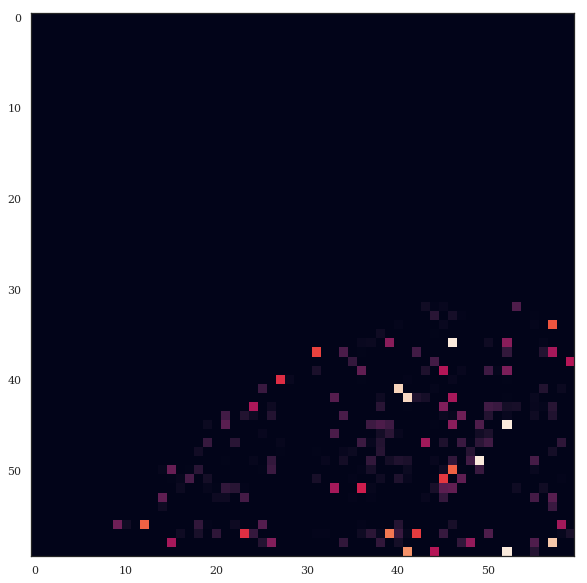

In [71]:
fig, axs = plt.subplots(figsize=(10,10))
axs.imshow(xstd_box,clim=(0,10))


In [4]:
t3.info()

<Table masked=True length=775153>
      name        dtype       unit     n_bad 
---------------- ------- ------------- ------
           DETID   int64                    0
           SRCID   int64                    0
        DR3SRCID   int32               376999
        DR3DETID   int32               479614
      DR3DETDIST float32        arcsec      0
      DR3SRCDIST float32        arcsec      0
         DR3MULT   int16               376999
        DR4SRCID   int32               187632
        DR4DETID   int32               247973
      DR4DETDIST float32        arcsec      0
      DR4SRCDIST float32        arcsec      0
         DR4MULT   int16               187632
         IAUNAME bytes21                    0
         SRC_NUM   int16                    0
          OBS_ID bytes10                    0
         REVOLUT  bytes4         orbit      0
       MJD_START float64             d      0
        MJD_STOP float64             d      0
       OBS_CLASS   int16                    0
